# This test doesn't use any labels at all, but evaluates models on their user assessed false positive and false negative rates after predictions are made. 

### Note: The Hawkears model is a multi species recognizer, and the predictions at the OSFL score output would normally be in the context of a few hundred other species predictions. For this test though, I have looked at the prediction at the OSFL output alone to make the comparison with the OSFL single species recognizer trainied in this project.

1. Make predictions on a recording
2. look at the model predictions sorted by confidence. 
3. Label all the positives and negatives in order of model confidence. 

In [1]:
# imports
from pathlib import Path
import sys
import shutil
BASE_PATH = Path.cwd().parent.parent
sys.path.append(str(BASE_PATH))
model_save_path = BASE_PATH / 'models'
import pandas as pd
import numpy as np
import opensoundscape as opso
from opensoundscape import audio
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from ipywidgets import interact
import glob
from src.utils import top_down_listen

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# load the test data
data_path = Path.cwd().parent.parent / "data"
test_df = pd.read_pickle(data_path / "interim" / "test_set" / "test_set.pkl")
ext_df = pd.read_csv(data_path / "raw" / "test_set" / "SingleSpecies_all.csv", low_memory=False)

In [3]:
# Load the target species examples from the external test set
ext_df = pd.read_csv(data_path / "raw" / "test_set" / "SingleSpecies_all.csv", low_memory=False)
# filter out all the other species
osfls = ext_df.loc[ext_df.species_code == "OSFL"]
# filter out the target species calls and keep the songs. 
osfls = osfls.loc[osfls.vocalization == "Song"]


In [4]:
recording_save_path = data_path / "raw" / "recordings" / "OSFL"
external_test_set_recordings = data_path / "processed" / "external_test_set_recordings"

def get_file_extension(url):
    file_type = url.split('.')[-1]
    return file_type
def make_filename(df):
    return f"recording-{df.recording_id}.{df.file_type}"

# Add a filename to the test recordings dataframe. 
osfls['file_type'] = osfls['recording_url'].apply(get_file_extension)
osfls['filename'] = osfls.apply(make_filename, axis=1)
external_test_set_filenames = osfls.filename.unique()
len(external_test_set_filenames), external_test_set_filenames

(39,
 array(['recording-255472.flac', 'recording-255412.mp3',
        'recording-255913.flac', 'recording-255938.flac',
        'recording-255940.flac', 'recording-255949.flac',
        'recording-255967.flac', 'recording-255980.flac',
        'recording-255420.mp3', 'recording-255419.mp3',
        'recording-255421.mp3', 'recording-255431.mp3',
        'recording-255432.mp3', 'recording-255433.mp3',
        'recording-255449.mp3', 'recording-255456.mp3',
        'recording-255454.mp3', 'recording-255457.mp3',
        'recording-255461.mp3', 'recording-255465.mp3',
        'recording-255539.flac', 'recording-255544.flac',
        'recording-255497.mp3', 'recording-255513.mp3',
        'recording-255518.mp3', 'recording-255526.mp3',
        'recording-255623.flac', 'recording-255624.flac',
        'recording-255625.flac', 'recording-255580.mp3',
        'recording-255581.mp3', 'recording-255582.mp3',
        'recording-255649.flac', 'recording-255607.mp3',
        'recording-255665.mp3'

# Save the recordings to disk ready for model to make predictions on entire long recordings

In [5]:

if not external_test_set_recordings.exists():
    external_test_set_recordings.mkdir(parents=True, exist_ok=True)
    for file in external_test_set_filenames:
        source = recording_save_path / file
        destination = external_test_set_recordings / file
        shutil.copy(source, destination)
        print(f"copied {source} to {destination}")
else:
    print(f"Recordings already saved to {external_test_set_recordings}")
        

Recordings already saved to /Users/mikeg/code/machine_learning/osfl_cnn_recognizer/data/processed/external_test_set_recordings


# The OSFL model was run using the predict.py program in the OSFL project root.
This is a similar scenario to how the model will be used in production.

# Processing times

39 recordings, 782.2mb <br>
Test 1 took 11 min 31 seconds to process with OSFL recognizer on 1 CPU core for preprocessing and used the GPU for inference on 2021 mac M1<br>
Test 2 took took 8 minutes<br>
Test 3 on Windows took 17 mins with 1 cpu core for preprocessing, and this decreased to 13 mins with 8 cores. This was on a ~2020 ROG gaming laptop

# Load the OSFL model predictions

In [23]:
osfl_model_predictions = pd.read_csv(BASE_PATH / "OSFL-scores.csv").sort_values(by="target_present", ascending=False)

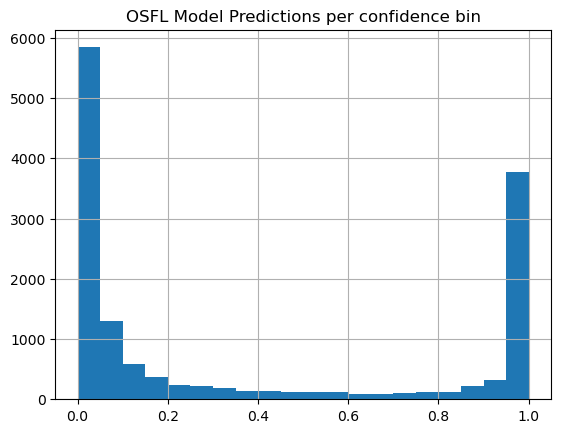

In [24]:
# change the name of the target present column to predictions
osfl_model_predictions = osfl_model_predictions.rename(columns={"target_present": "predicted"})
plot = osfl_model_predictions.predicted.hist(bins=20)
plot.title.set_text("OSFL Model Predictions per confidence bin")

#### Save the predictions in a dataframe

In [25]:
osfl_model_predictions.file = "../../" + osfl_model_predictions.file
osfl_model_predictions

,file,start_time,end_time,predicted
3093,../../data/processed/external_test_set_recordi...,459.0,462.0,0.999997
3112,../../data/processed/external_test_set_recordi...,487.5,490.5,0.999996
8885,../../data/processed/external_test_set_recordi...,175.5,178.5,0.999995
3020,../../data/processed/external_test_set_recordi...,349.5,352.5,0.999995
3167,../../data/processed/external_test_set_recordi...,570.0,573.0,0.999994
...,...,...,...,...
13629,../../data/processed/external_test_set_recordi...,123.0,126.0,0.000297
9255,../../data/processed/external_test_set_recordi...,133.5,136.5,0.000287
13619,../../data/processed/external_test_set_recordi...,108.0,111.0,0.000237
13630,../../data/processed/external_test_set_recordi...,124.5,127.5,0.000200


# The HawkEars model was run on the same data by using the analyze.py function in hawkears root. 
### This took 66 mins on the mac M1 CPU.
it would be faster if it ran on the GPU but this wasn't an option on the mac.

# Load the hawkears predictions on the test recordings and parse the input. 

In [161]:
hawkears_files = glob.glob(str(data_path / "processed" / "hawkears"/"*.*"))

In [162]:
results = []
# Read and parse the hawkears file contents
for file_path in hawkears_files:
    with open(file_path, "r") as f:
        file_content = f.read().strip().split("\n")
        file_id = file_path.split("/")[-1].split("-")[1]
        file_id = file_id.split("_")[0]
        for detection in file_content:
            if detection:
                line = [file_id] + detection.split("\t")
            else:
                line = [file_id]
            results.append(line)
# Convert the results to a pandas DataFrame
df = pd.DataFrame(
    results, columns=["file_id", "start_time", "end_time", "species;confidence"]
)
df.file_id = df.file_id.astype(int)
df.sort_values(by=["file_id"], inplace=True)
df[["species", "confidence"]] = df["species;confidence"].str.split(";", expand=True)
df.drop(columns=["species;confidence"], inplace=True)
df = df.loc[df["species"] == "OSFL"]
df.confidence = df.confidence.astype(float)
hawkears_preds = df
hawkears_preds.rename(columns={"confidence":"hawkears_prediction"} , inplace=True)


In [28]:
hawkears_preds.head()

,file_id,start_time,end_time,species,hawkears_prediction
3815912,255412,255.00,258.00,OSFL,0.00
3815913,255412,256.50,259.50,OSFL,0.01
3815914,255412,258.00,261.00,OSFL,0.00
3815915,255412,259.50,262.50,OSFL,0.00
3815916,255412,261.00,264.00,OSFL,0.01


# Merge the data from OSFL.model and hawkears

In [29]:
# Set multi-index of the dataframe. 
osfl_model_predictions.set_index(["file", "start_time", "end_time"], inplace=True)

# Add a column containing the file id to merge on later. 
def get_rec_id_from_index(file_path):
    return file_path.split("/")[-1].split("-")[1].split(".")[0]
osfl_model_predictions['file_id'] = osfl_model_predictions.index.get_level_values('file').map(get_rec_id_from_index).astype(int)
osfl_model_predictions_reset = osfl_model_predictions.reset_index()

# Make all the datatypes the same
hawkears_preds.start_time = hawkears_preds.start_time.astype(float)
hawkears_preds.end_time = hawkears_preds.end_time.astype(float)
osfl_model_predictions_reset.start_time = osfl_model_predictions_reset.start_time.astype(float)
osfl_model_predictions_reset.end_time = osfl_model_predictions_reset.end_time.astype(float)
osfl_model_predictions_reset.file_id.astype(int)

# Merge the two dataframes by the file_id, start_time and end_time so we know that each prediction refers to the same audio clip
merged_df = pd.merge(osfl_model_predictions_reset, hawkears_preds, on=["file_id", "start_time", "end_time"],suffixes=('_df1', '_df2'))
merged_df

,file,start_time,end_time,predicted,file_id,species,hawkears_prediction
0,../../data/processed/external_test_set_recordi...,459.0,462.0,0.999997,255625,OSFL,0.98
1,../../data/processed/external_test_set_recordi...,487.5,490.5,0.999996,255625,OSFL,0.99
2,../../data/processed/external_test_set_recordi...,175.5,178.5,0.999995,255454,OSFL,0.86
3,../../data/processed/external_test_set_recordi...,349.5,352.5,0.999995,255625,OSFL,0.98
4,../../data/processed/external_test_set_recordi...,570.0,573.0,0.999994,255625,OSFL,0.98
...,...,...,...,...,...,...,...
14187,../../data/processed/external_test_set_recordi...,123.0,126.0,0.000297,255421,OSFL,0.01
14188,../../data/processed/external_test_set_recordi...,133.5,136.5,0.000287,255949,OSFL,0.01
14189,../../data/processed/external_test_set_recordi...,108.0,111.0,0.000237,255421,OSFL,0.01
14190,../../data/processed/external_test_set_recordi...,124.5,127.5,0.000200,255421,OSFL,0.01


Text(0.5, 1.0, 'Hawkears Predictions per confidence bin')

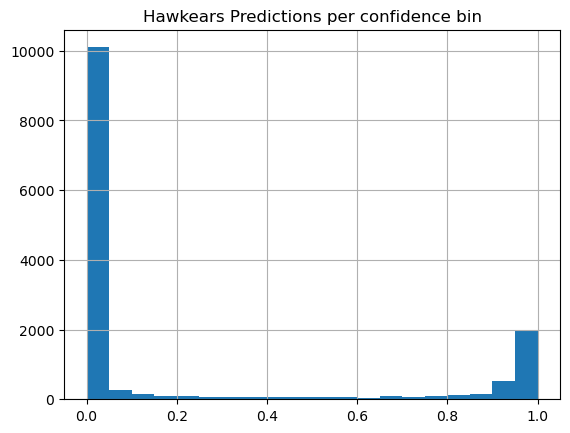

In [30]:
plot = merged_df.hawkears_prediction.hist(bins=20)
plot.set_title("Hawkears Predictions per confidence bin")

The amount of validation effort required to process these top scoring predictions for each model would take 30 hours based on an expected validation time of 5 hours per 1000 samples. 
There are 5000 + confident predictions made by the OSFL model which scored over 0.8, and there are 2500 found by HawkEars on the same data. 

To make the top down listening easier, we can take a sample of the recordings so that the listening work only takes a couple of hours. 

# Choose a sample of the recordings which isn't going to take too long to get through


In [31]:
merged_df.set_index(["file", "start_time", "end_time"], inplace=True)

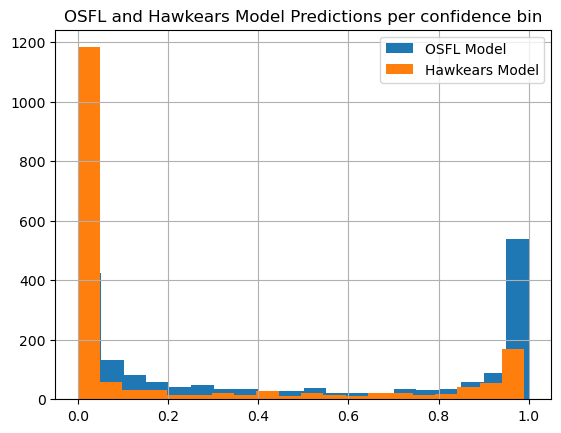

In [51]:
np.random.seed(42)
recordings = merged_df.index.get_level_values("file").unique()
sample = np.random.choice(recordings, 5)
sample_df = merged_df.loc[sample]
plot = merged_df.loc[sample].predicted.hist(bins=20), merged_df.loc[sample].hawkears_prediction.hist(bins=20)
plot[0].set_title("OSFL and Hawkears Model Predictions per confidence bin")
plt.legend(["OSFL Model", "Hawkears Model"])
plt.show()


# Top down listening
### This process allows us to listen to the highest scoring predictions per model one by one and evaluate them as present or absent. 


## A label of 1 means Present
## A label of 2 means Absent

In [55]:
# Take the data and sort by prediction confidence for each model. 
top_down_hawkears = sample_df[["hawkears_prediction"]].copy()
top_down_hawkears.rename(columns={"hawkears_prediction":"predicted"}, inplace=True)
top_down_hawkears.sort_values(by="predicted", ascending=False, inplace=True)

top_down_osfl = sample_df[["predicted"]].copy()
top_down_osfl.sort_values(by="predicted", ascending=False, inplace=True)
top_down_osfl.head()

predicted
file                                               start_time end_time           
../../data/processed/external_test_set_recordin... 361.5      364.5      0.999953
                                                   357.0      360.0      0.999923
                                                   559.5      562.5      0.999879
../../data/processed/external_test_set_recordin... 367.5      370.5      0.999863
                                                   435.0      438.0      0.999784

('../../data/processed/external_test_set_recordings/recording-256035.mp3', 559.5, 562.5)
prediction = 0.999879


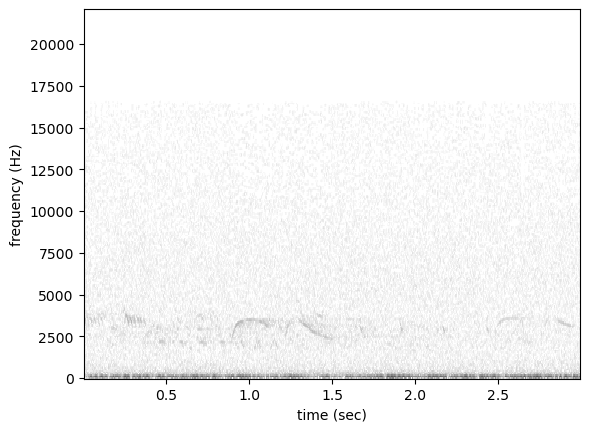

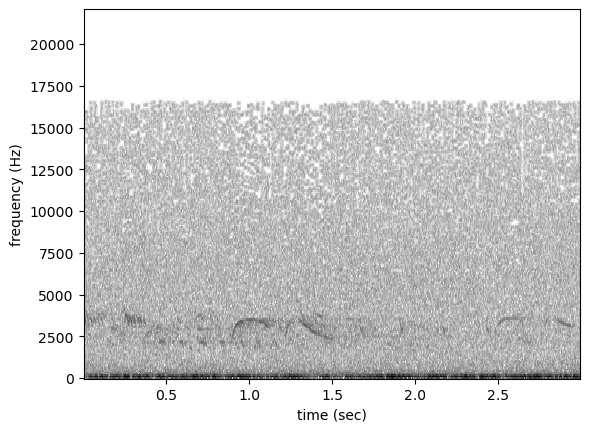

top down listening mode: press enter to autolabel as present or 2 for absent
added confidence tag 1 to the dataframe.
verification counts for all clips
confidence_cat
0    1790
1       3
Name: count, dtype: int64


/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/src/utils.py:474: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[clip_idx, "confidence_cat"] = int(user_confidence)


In [59]:
top_down_listen(top_down_osfl)

In [564]:
top_down_osfl.to_pickle(data_path / "interim" / "top_down_osfl.pkl")

In [2304]:
top_down_hawkears.iloc[:500].confidence_cat.value_counts(), top_down_osfl.iloc[:500].confidence_cat.value_counts()  

(confidence_cat
 1    496
 2      4
 Name: count, dtype: int64,
 confidence_cat
 1    498
 2      2
 Name: count, dtype: int64)

The results are very similar at this stage - and most of the samples in the top 500 were of the olive sided flycatcher in both models. The 6 and 8 which were flagged as not OSFL could have contained an OSFL. 

# Check the next 500 predictions of each model

('../../data/processed/external_test_set_recordings/recording-255544.flac', 427.5, 430.5)
prediction = 0.295203


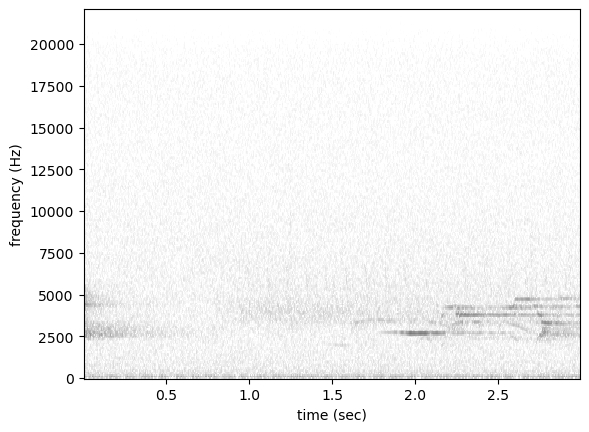

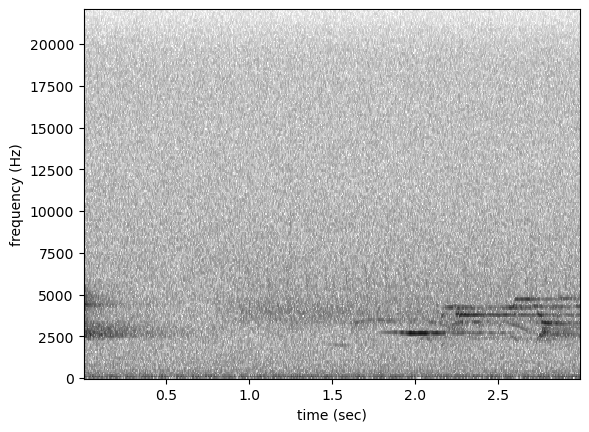

top down listening mode: press enter to autolabel as present or 2 for absent
added confidence tag 2 to the dataframe.
verification counts for all clips
confidence_cat
1    814
0    774
2    205
Name: count, dtype: int64


/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/src/utils.py:474: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[clip_idx, "confidence_cat"] = int(user_confidence)


predicted  \
file                                               start_time end_time              
../../data/processed/external_test_set_recordin... 361.5      364.5      0.999953   
                                                   357.0      360.0      0.999923   
                                                   559.5      562.5      0.999879   
../../data/processed/external_test_set_recordin... 367.5      370.5      0.999863   
                                                   435.0      438.0      0.999784   
...                                                                           ...   
../../data/processed/external_test_set_recordin... 112.5      115.5      0.002052   
                                                   7.5        10.5       0.001869   
../../data/processed/external_test_set_recordin... 204.0      207.0      0.001797   
../../data/processed/external_test_set_recordin... 223.5      226.5      0.001672   
                                                   235.5      238.5      0.001638   

                                                                        confidence_cat  
file                                               start_time end_time                  
../../data/processed/external_test_set_recordin... 361.5      364.5                  1  
                                                   357.0      360.0                  1  
                                                   559.5      562.5                  1  
../../data/processed/external_test_set_recordin... 367.5      370.5                  1  
                                                   435.0      438.0                  1  
...                                                                                ...  
../../data/processed/external_test_set_recordin... 112.5      115.5                  0  
                                                   7.5        10.5                   0  
../../data/processed/external_test_set_recordin... 204.0      207.0                  0  
../../data/processed/external_test_set_recordin... 223.5      226.5                  0  
                                                   235.5      238.5                  0  

[1793 rows x 2 columns]

In [2097]:
top_down_listen(top_down_osfl)

In [2098]:
top_down_osfl.to_pickle(data_path / "interim" / "top_down_osfl.pkl")

('../../data/processed/external_test_set_recordings/recording-256035.mp3', 57.0, 60.0)
prediction = 0.01


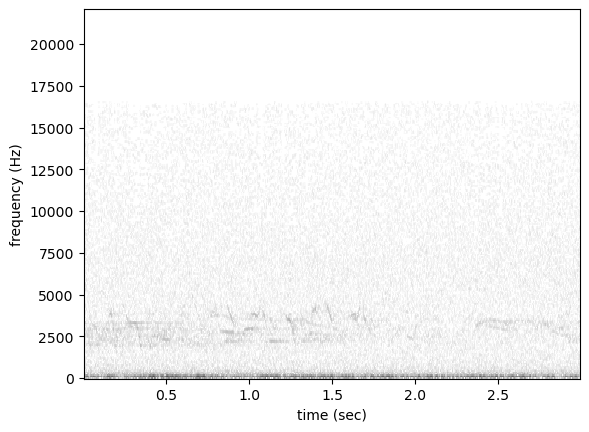

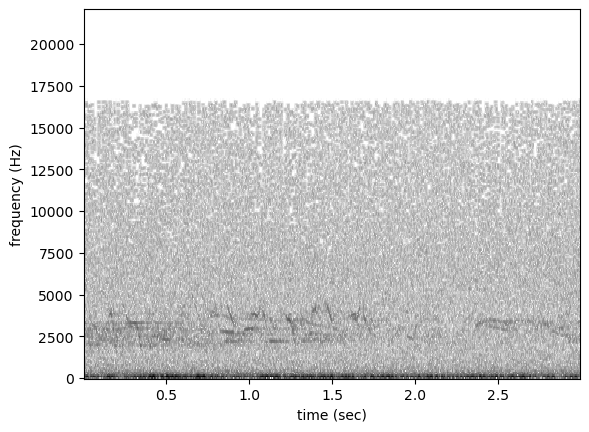

top down listening mode: press enter to autolabel as present or 2 for absent
added confidence tag 1 to the dataframe.
verification counts for all clips
confidence_cat
1    795
0    789
2    209
Name: count, dtype: int64


/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/src/utils.py:474: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[clip_idx, "confidence_cat"] = int(user_confidence)


predicted  \
file                                               start_time end_time              
../../data/processed/external_test_set_recordin... 133.5      136.5          0.99   
../../data/processed/external_test_set_recordin... 243.0      246.0          0.99   
../../data/processed/external_test_set_recordin... 507.0      510.0          0.99   
                                                   568.5      571.5          0.99   
                                                   282.0      285.0          0.99   
...                                                                           ...   
../../data/processed/external_test_set_recordin... 208.5      211.5          0.00   
../../data/processed/external_test_set_recordin... 189.0      192.0          0.00   
                                                   292.5      295.5          0.00   
../../data/processed/external_test_set_recordin... 82.5       85.5           0.00   
../../data/processed/external_test_set_recordin... 10.5       13.5           0.00   

                                                                        confidence_cat  
file                                               start_time end_time                  
../../data/processed/external_test_set_recordin... 133.5      136.5                  1  
../../data/processed/external_test_set_recordin... 243.0      246.0                  1  
../../data/processed/external_test_set_recordin... 507.0      510.0                  1  
                                                   568.5      571.5                  1  
                                                   282.0      285.0                  1  
...                                                                                ...  
../../data/processed/external_test_set_recordin... 208.5      211.5                  0  
../../data/processed/external_test_set_recordin... 189.0      192.0                  0  
                                                   292.5      295.5                  0  
../../data/processed/external_test_set_recordin... 82.5       85.5                   0  
../../data/processed/external_test_set_recordin... 10.5       13.5                   0  

[1793 rows x 2 columns]

In [1865]:
top_down_listen(top_down_hawkears)

In [2099]:
top_down_hawkears.to_pickle(data_path / "interim" / "top_down_hawkears.pkl")

In [120]:
# Check which labels didn't match and re-visit those examples
merged=pd.merge(top_down_osfl, top_down_hawkears, on=["file", "start_time", "end_time"],suffixes=('_osfl', '_hawkears'))

unmatched_index = merged.loc[merged.confidence_cat_osfl != 0].loc[merged.confidence_cat_hawkears != 0].loc[merged.confidence_cat_osfl != merged.confidence_cat_hawkears].index

top_down_osfl.loc[unmatched_index, "confidence_cat"] = 0
top_down_hawkears.loc[unmatched_index, "confidence_cat"] = 0


In [ ]:
top_down_listen(top_down_osfl)

In [ ]:
top_down_listen(top_down_hawkears)

In [ ]:
# Save the cleaned top-down listening data
# top_down_hawkears.to_pickle(data_path / "interim" / "top_down_hawkears_cleaned.pkl")
# top_down_osfl.to_pickle(data_path / "interim" / "top_down_osfl_cleaned.pkl")

# Load the cleaned top down data if it has already been done

In [119]:
top_down_hawkears=pd.read_pickle(data_path / "interim" / "top_down_hawkears_cleaned.pkl")
top_down_osfl=pd.read_pickle(data_path / "interim" / "top_down_osfl_cleaned.pkl")

# We now have 1000 predictions in order of confidence from each model. 
- 99% of the top 500 were all OSFL calls for both models.
- In the next 500 calls, the OSFL samples became mixed in with other bird calls and absent audio for both models.
- The results are shown below


In [111]:
top_down_osfl.iloc[:1000].confidence_cat.value_counts(), top_down_hawkears.iloc[:1000].confidence_cat.value_counts()

(confidence_cat
 1    817
 2    183
 Name: count, dtype: int64,
 confidence_cat
 1    790
 2    210
 Name: count, dtype: int64)

The OSFL specific model found 817 OSFL calls in the top 1000 predictions. The HawkEars model showed 790. The distribution of these is shown below. 

# Plot the predictions in rank order

In [ ]:
# make numeric index
top_down_osfl.reset_index(inplace=True)
top_down_hawkears.reset_index(inplace=True)

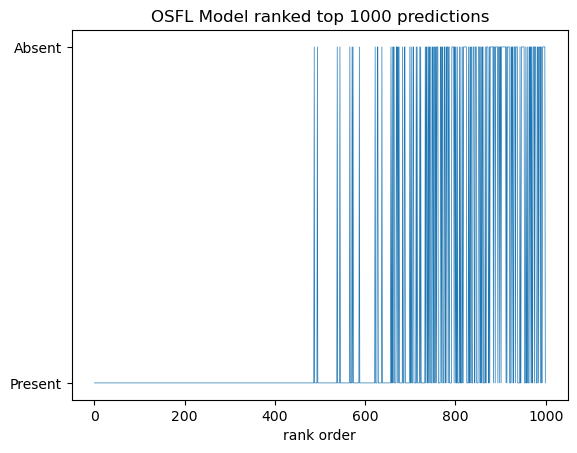

In [113]:
# Plot the confidence_cat column with x as the index
plot = plt.plot(top_down_osfl.index[:1000], top_down_osfl.confidence_cat[:1000])
plt.title("OSFL Model ranked top 1000 predictions")
plt.setp(plot, linewidth=0.5)
plt.yticks([1, 2], ["Present", "Absent"])
plt.xlabel("rank order")
plt.show()

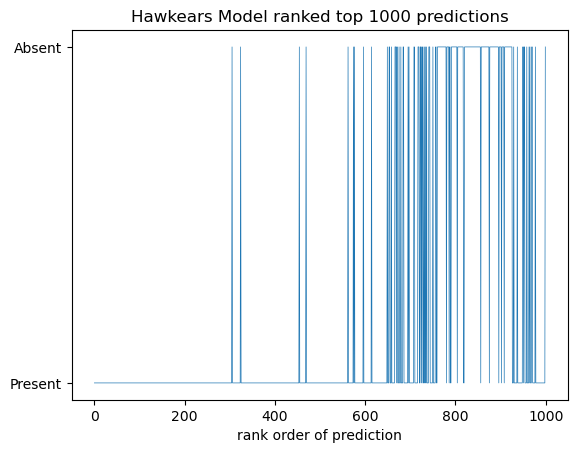

In [160]:
plot = plt.plot(top_down_hawkears.index[:1000], top_down_hawkears.confidence_cat[:1000])

# make the plot wider


plt.title("Hawkears Model ranked top 1000 predictions")
# make the lines thinner
plt.setp(plot, linewidth=0.5)
# set the y label to present or absent
plt.yticks([1, 2], ["Present", "Absent"])
plt.xlabel("rank order of prediction")

plt.show()

# The predictions made by the OSFL model have more separation between the main cluster of positives and the main cluster of negatives. 
- This means that the false positives will start to show up later and when using this model in a top down manner.
- The Hawkears output places more of the OSFL detections after absent clips.

# The models confidence behaved differently as we went through the rank ordered predictions
- The confidence of the hawkears scores fell more rapidly than the confidence of the OSFL model

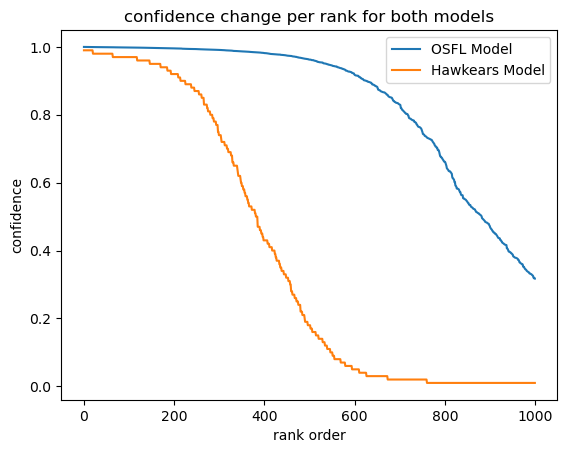

In [159]:
#plot the index against the confidence for both dataframes
plt.plot(top_down_osfl.index[:1000], top_down_osfl.predicted[:1000])
plt.plot(top_down_hawkears.index[:1000], top_down_hawkears.predicted[:1000])
plt.title("confidence change per rank for both models")
plt.ylabel("confidence")
plt.xlabel("rank order")
plt.legend(["OSFL Model", "Hawkears Model"])
plt.show()

Both models reach a lower plateau where every rank order prediction is around zero, but the hawkears model gets there a little sooner - it is more discriminitive.  This means that all things being equal, a higher threshold would have to be chosen when using the OSFL model compared with the Hawkears model to retrn the same number of positive IDs, and the threshold would be very sensitive in this region. 

# Conclusion
This experiment was run on a small section of 5 audio recordigns from 5 locations in north west Canada. It is not representative of the entire spread of habitats in North America, but it does provide a test which is similar to one of the likely intended use cases of the model - running on audio from a specific project. 

The OSFL model returned a high number of samples of one other species besides the Olive Sided Flycatcher. This must have been a species which didn't make it into the reinforcement dataset __other_habitats_df__. 

## witnessing the effects of re-training using the __other_habitats__ data

After the first iteration of OSFL model training, the Western Wood Pewee was present as false positives in a very high number of detections in the __other_habitats__ data. The current OSFL-model was re-trained with those high scoring false positives in the training set. During top-down-listening, there were some of the Western Wood Pewee songs in the test recordings. These scored very low compared with other OSFL songs, and lower than they did before re-training. 

This demonstrates that the strategy of getting the model's predictions on a dataset, then re-training the model on those false positives can be an effective strategy for reducing those false positives. It also demonstrates the need for a large set of data to improve on this strategy: since there were still "confuser species" which slipped through the net and ended up being recognized with a higher probability than actual OSFL calls. Despite this, the OSFL specific model still returned more OSFL scores and the negatives were clustered more tightly than the Hawkears model for the same species. 

It must be remembered that this test ignores the fact that a hawkears output would have corresponding likelihoods for each species, so those species which sound like an OSFL and scored higher than other OSFLs would likely have a corresponding other species present, and these cases wouldn't be such a big deal since we'd pick the other species with the higher score. 

Therefore the use case of the model becomes important. If the purpose is just to detect Olive Sided Flycatchers, even in the presence of other species, the OSFL model can be used for this purpose and results might be better than HawkEars for this purpose. 

Comparing machine learning models on like for like datasets is tricky - there are many factors to consider:
- Reported metrics aren't usually directly comparable unless the models have been tested on the same test datasets. 
- Avoiding data leakage when selecting training data is important to get a fairer measure of expected model performance. Steps must be taken to avoid training the model on examples from the test set. 

#### This project took an approach which trains a model on audio which is as similar as possible to the audio which will be used at inference time
- training audio included mp3 and flac recordings from across Canada. There was audio from a range of mp3 qualities, with all the kinds of background noise and other species present as would be found in the field.
- The model can be expected to perform with those same metrics reported in this project, within the area of data included in the test set, which can be seen on the maps of notebook 6.
